# Vehicle Detection and Tracking

The goals of this project is to write a software pipeline to detect vehicles in a video. Steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
3. For those first two steps normalize extracted features and randomize a selection for training and testing.
4. Implement a sliding-window technique and use trained classifier to search for vehicles in images.
5. Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.

# Import all required libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
# for scikit-learn version <= 0.17 use
#from sklearn.cross_validation import train_test_split
# if using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler
import pickle   
import time
from sklearn import svm
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline

# Data Exploration

In [2]:
#Read dataset for cars and non-cars
cars = glob.glob('dataset/vehicles/**/*.png')
notcars = glob.glob('dataset/non-vehicles/**/*.png')
rndm_image =  mpimg.imread(cars[np.random.randint(0,len(cars))])
print("Number of car images: ", len(cars))
print("Number of Non-car images: ", len(notcars))
print("Size of each image: ", rndm_image.shape)
print("Data type: ", rndm_image.dtype)

Number of car images:  8792
Number of Non-car images:  8968
Size of each image:  (64, 64, 3)
Data type:  float32


## Visualizing some images in dataset

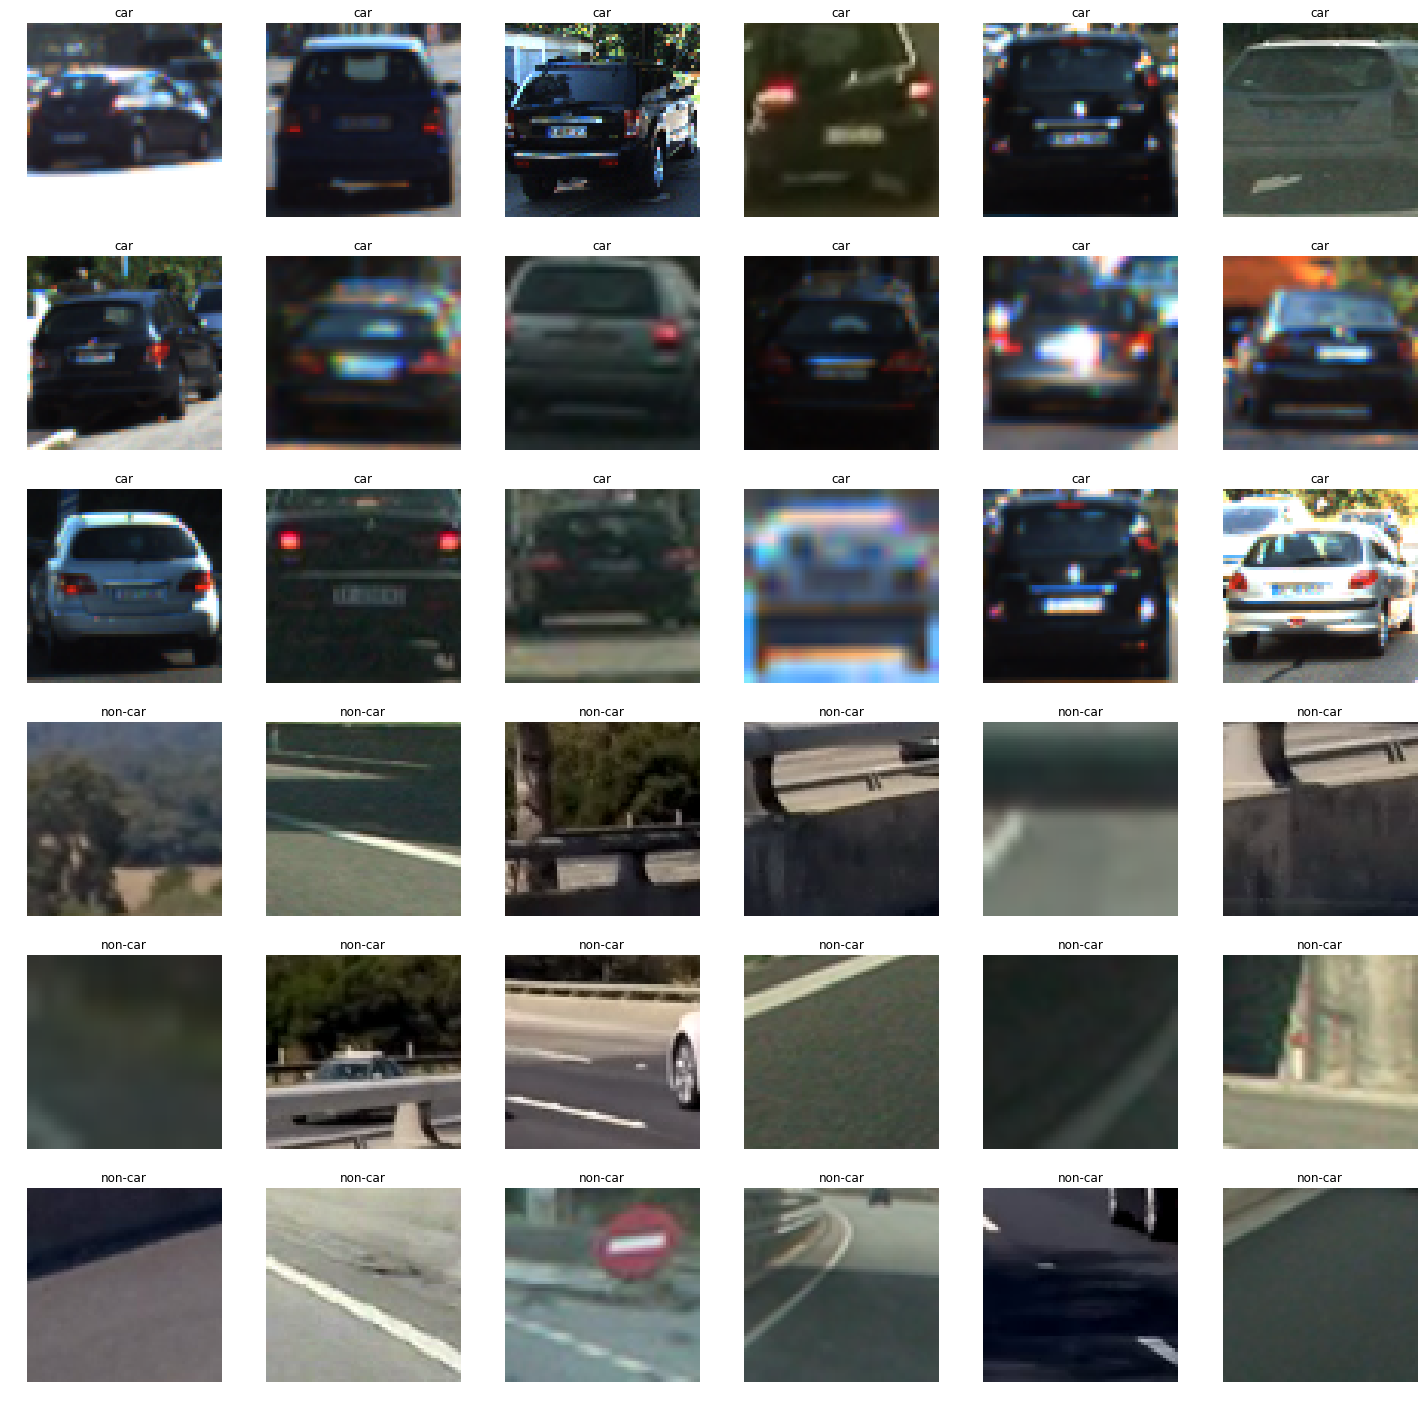

In [3]:
# Visualize data
f, axs = plt.subplots(6,6, figsize=(25, 25))
axs = axs.ravel()
for i in np.arange(18):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    axs[i].axis('off')
    axs[i].set_title('car')
    axs[i].imshow(img)
    
for i in np.arange(18,36):
    img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    axs[i].axis('off')
    axs[i].set_title('non-car')
    axs[i].imshow(img)

# Histogram of Oriented Gradients (HOG)

Define a function to return HOG features and visualization. Features will always be the first element of the return. Image data will be returned as the second element if visualize= True, otherwise there is no second return element.

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Visualizing HOG on an image from dataset

Image index:  10
HOG feature vector shape:  (396,)


(-0.5, 63.5, 63.5, -0.5)

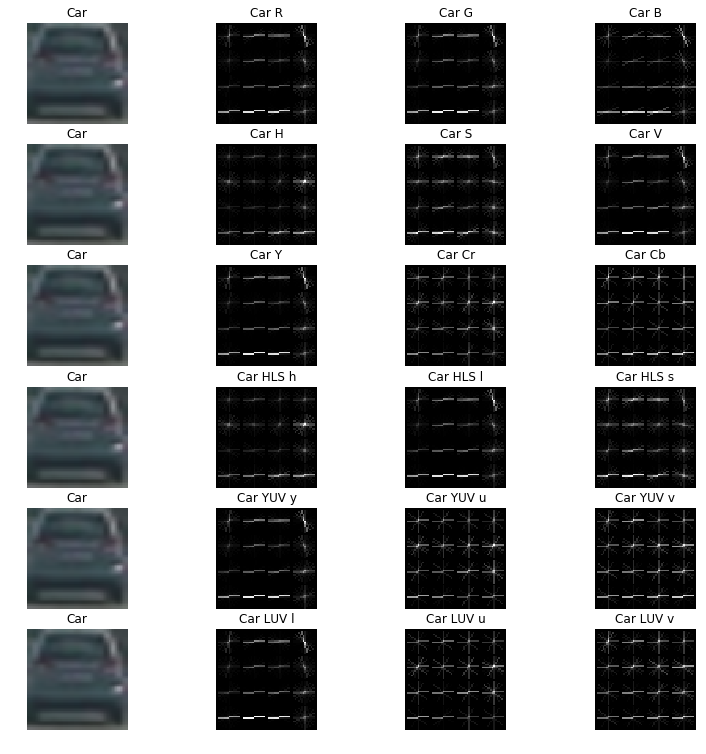

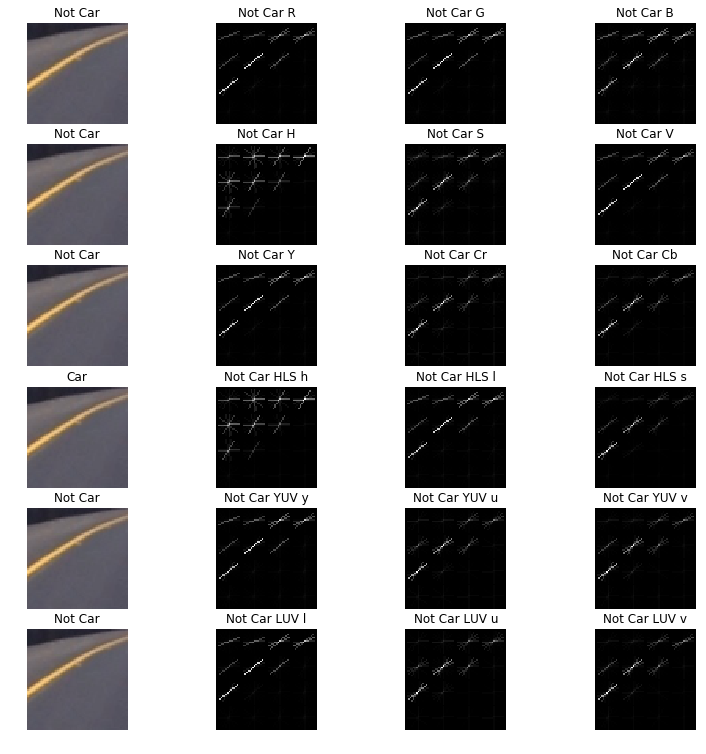

In [5]:
# Read in our vehicles
car_images = np.copy(cars)
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
ind=10
print("Image index: ", ind)

# Read in the image
car = cv2.imread(cars[ind])
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
notcar = cv2.imread(notcars[ind])
notcar = cv2.cvtColor(notcar, cv2.COLOR_BGR2RGB)

orient = 11
pix_per_cell = 16
cell_per_block = 2
####RGB Color Space####
# Call our function with vis=True to see an image output
_, car_hog_r = get_hog_features(car[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, car_hog_g = get_hog_features(car[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, car_hog_b=  get_hog_features(car[:,:,2], orient= 8, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)

_, ncar_hog_r = get_hog_features(notcar[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_g = get_hog_features(notcar[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_b = get_hog_features(notcar[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)


####HSV Color Space####
c_hsv = cv2.cvtColor(car, cv2.COLOR_RGB2HSV)
nc_hsv = cv2.cvtColor(notcar, cv2.COLOR_RGB2HSV)
# Call our function with vis=True to see an image output
_, car_hog_h = get_hog_features(c_hsv[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, car_hog_s = get_hog_features(c_hsv[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, car_hog_v=  get_hog_features(c_hsv[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)

_, ncar_hog_h = get_hog_features(nc_hsv[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_s = get_hog_features(nc_hsv[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_v = get_hog_features(nc_hsv[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)

####YCrCb Color Space####
c_ycrcb = cv2.cvtColor(car, cv2.COLOR_RGB2YCrCb)
nc_ycrcb = cv2.cvtColor(notcar, cv2.COLOR_RGB2YCrCb)
# Call our function with vis=True to see an image output
_, car_hog_y =  get_hog_features(c_ycrcb[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, car_hog_cr = get_hog_features(c_ycrcb[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, car_hog_cb=  get_hog_features(c_ycrcb[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)

_, ncar_hog_y =  get_hog_features(nc_ycrcb[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, ncar_hog_cr = get_hog_features(nc_ycrcb[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_cb = get_hog_features(nc_ycrcb[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)

####HLS Color Space####
c_hls = cv2.cvtColor(car, cv2.COLOR_RGB2HLS)
nc_hls = cv2.cvtColor(notcar, cv2.COLOR_RGB2HLS)
# Call our function with vis=True to see an image output
_, car_hog_hls_h =  get_hog_features(c_hls[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, car_hog_hls_l = get_hog_features(c_hls[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, car_hog_hls_s=  get_hog_features(c_hls[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)

_, ncar_hog_hls_h =  get_hog_features(nc_hls[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_hls_l = get_hog_features(nc_hls[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                        vis=True, feature_vec=True)
_, ncar_hog_hls_s = get_hog_features(nc_hls[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)

####YUV Color Space####
c_yuv = cv2.cvtColor(car, cv2.COLOR_RGB2YUV)
nc_yuv = cv2.cvtColor(notcar, cv2.COLOR_RGB2YUV)
# Call our function with vis=True to see an image output
_, car_hog_yuv_y =  get_hog_features(c_yuv[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, car_hog_yuv_u = get_hog_features(c_yuv[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, car_hog_yuv_v=  get_hog_features(c_yuv[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)

_, ncar_hog_yuv_y =  get_hog_features(nc_yuv[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, ncar_hog_yuv_u = get_hog_features(nc_yuv[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, ncar_hog_yuv_v = get_hog_features(nc_yuv[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)

####LUV Color Space####
c_luv = cv2.cvtColor(car, cv2.COLOR_RGB2LUV)
nc_luv = cv2.cvtColor(notcar, cv2.COLOR_RGB2LUV)
# Call our function with vis=True to see an image output
_, car_hog_luv_l =  get_hog_features(c_luv[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, car_hog_luv_u = get_hog_features(c_luv[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, car_hog_luv_v=  get_hog_features(c_luv[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)

_, ncar_hog_luv_l =  get_hog_features(nc_luv[:,:,0], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
_, ncar_hog_luv_u = get_hog_features(nc_luv[:,:,1], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
features, ncar_hog_luv_v = get_hog_features(nc_luv[:,:,2], orient= orient, 
                        pix_per_cell= pix_per_cell, cell_per_block= cell_per_block,
                        vis=True, feature_vec=True)
print("HOG feature vector shape: ", features.shape)
#Visualize HOG's
f, axs = plt.subplots(6,4, figsize=(13,13))
axs = axs.ravel()
axs[0].imshow(car)
axs[0].set_title('Car')
axs[0].axis('off')
axs[1].imshow(car_hog_r, cmap='gray')
axs[1].set_title('Car R')
axs[1].axis('off')
axs[2].imshow(car_hog_g, cmap='gray')
axs[2].set_title('Car G')
axs[2].axis('off')
axs[3].imshow(car_hog_b, cmap='gray')
axs[3].set_title('Car B')
axs[3].axis('off')
axs[4].imshow(car)
axs[4].set_title('Car')
axs[4].axis('off')
axs[5].imshow(car_hog_h, cmap='gray')
axs[5].set_title('Car H')
axs[5].axis('off')
axs[6].imshow(car_hog_s, cmap='gray')
axs[6].set_title('Car S')
axs[6].axis('off')
axs[7].imshow(car_hog_v, cmap='gray')
axs[7].set_title('Car V')
axs[7].axis('off')
axs[8].imshow(car)
axs[8].set_title('Car')
axs[8].axis('off')
axs[9].imshow(car_hog_y, cmap='gray')
axs[9].set_title('Car Y')
axs[9].axis('off')
axs[10].imshow(car_hog_cr, cmap='gray')
axs[10].set_title('Car Cr')
axs[10].axis('off')
axs[11].imshow(car_hog_cb, cmap='gray')
axs[11].set_title('Car Cb')
axs[11].axis('off')
axs[12].imshow(car)
axs[12].set_title('Car')
axs[12].axis('off')
axs[13].imshow(car_hog_hls_h, cmap='gray')
axs[13].set_title('Car HLS h')
axs[13].axis('off')
axs[14].imshow(car_hog_hls_l, cmap='gray')
axs[14].set_title('Car HLS l')
axs[14].axis('off')
axs[15].imshow(car_hog_hls_s, cmap='gray')
axs[15].set_title('Car HLS s')
axs[15].axis('off')
axs[16].imshow(car)
axs[16].set_title('Car')
axs[16].axis('off')
axs[17].imshow(car_hog_yuv_y, cmap='gray')
axs[17].set_title('Car YUV y')
axs[17].axis('off')
axs[18].imshow(car_hog_yuv_u, cmap='gray')
axs[18].set_title('Car YUV u')
axs[18].axis('off')
axs[19].imshow(car_hog_yuv_v, cmap='gray')
axs[19].set_title('Car YUV v')
axs[19].axis('off')
axs[20].imshow(car)
axs[20].set_title('Car')
axs[20].axis('off')
axs[21].imshow(car_hog_luv_l, cmap='gray')
axs[21].set_title('Car LUV l')
axs[21].axis('off')
axs[22].imshow(car_hog_luv_u, cmap='gray')
axs[22].set_title('Car LUV u')
axs[22].axis('off')
axs[23].imshow(car_hog_luv_v, cmap='gray')
axs[23].set_title('Car LUV v')
axs[23].axis('off')

f, axs = plt.subplots(6,4, figsize=(13,13))
axs = axs.ravel()
axs[0].imshow(notcar)
axs[0].set_title('Not Car')
axs[0].axis('off')
axs[1].imshow(ncar_hog_r, cmap='gray')
axs[1].set_title('Not Car R')
axs[1].axis('off')
axs[2].imshow(ncar_hog_g, cmap='gray')
axs[2].set_title('Not Car G')
axs[2].axis('off')
axs[3].imshow(ncar_hog_b, cmap='gray')
axs[3].set_title('Not Car B')
axs[3].axis('off')
axs[4].imshow(notcar)
axs[4].set_title('Not Car')
axs[4].axis('off')
axs[5].imshow(ncar_hog_h, cmap='gray')
axs[5].set_title('Not Car H')
axs[5].axis('off')
axs[6].imshow(ncar_hog_s, cmap='gray')
axs[6].set_title('Not Car S')
axs[6].axis('off')
axs[7].imshow(ncar_hog_v, cmap='gray')
axs[7].set_title('Not Car V')
axs[7].axis('off')
axs[8].imshow(notcar)
axs[8].set_title('Not Car')
axs[8].axis('off')
axs[9].imshow(ncar_hog_y, cmap='gray')
axs[9].set_title('Not Car Y')
axs[9].axis('off')
axs[10].imshow(ncar_hog_cr, cmap='gray')
axs[10].set_title('Not Car Cr')
axs[10].axis('off')
axs[11].imshow(ncar_hog_cb, cmap='gray')
axs[11].set_title('Not Car Cb')
axs[11].axis('off')
axs[12].imshow(notcar)
axs[12].set_title('Car')
axs[12].axis('off')
axs[13].imshow(ncar_hog_hls_h, cmap='gray')
axs[13].set_title('Not Car HLS h')
axs[13].axis('off')
axs[14].imshow(ncar_hog_hls_l, cmap='gray')
axs[14].set_title('Not Car HLS l')
axs[14].axis('off')
axs[15].imshow(ncar_hog_hls_s, cmap='gray')
axs[15].set_title('Not Car HLS s')
axs[15].axis('off')
axs[16].imshow(notcar)
axs[16].set_title('Not Car')
axs[16].axis('off')
axs[17].imshow(ncar_hog_yuv_y, cmap='gray')
axs[17].set_title('Not Car YUV y')
axs[17].axis('off')
axs[18].imshow(ncar_hog_yuv_u, cmap='gray')
axs[18].set_title('Not Car YUV u')
axs[18].axis('off')
axs[19].imshow(ncar_hog_yuv_v, cmap='gray')
axs[19].set_title('Not Car YUV v')
axs[19].axis('off')
axs[20].imshow(notcar)
axs[20].set_title('Not Car')
axs[20].axis('off')
axs[21].imshow(ncar_hog_luv_l, cmap='gray')
axs[21].set_title('Not Car LUV l')
axs[21].axis('off')
axs[22].imshow(ncar_hog_luv_u, cmap='gray')
axs[22].set_title('Not Car LUV u')
axs[22].axis('off')
axs[23].imshow(ncar_hog_luv_v, cmap='gray')
axs[23].set_title('Not Car LUV v')
axs[23].axis('off')


# Histogram of Color

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    #Generating bin centers,Each of the histograms in this case have the same bins,
    #so just using the rhist bin edges
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


## Visualizing Hisogram of color on an image from dataset

Histogram feature vector shape:  (96,)


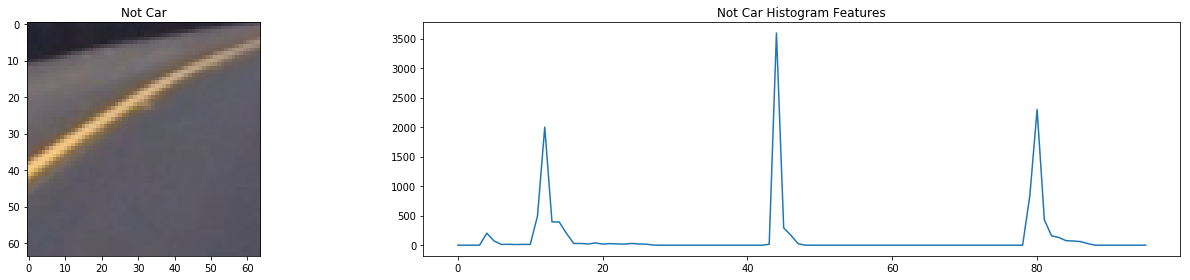

In [7]:
# Read in the image
ind = np.random.randint(0, len(car_images))
ind=10
# Read in the image
car = cv2.imread(cars[ind])
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
notcar = cv2.imread(notcars[ind])
notcar = cv2.cvtColor(notcar, cv2.COLOR_BGR2RGB)

cvtd_c = cv2.cvtColor(car, cv2.COLOR_RGB2LUV)
cvtd_nc = cv2.cvtColor(notcar, cv2.COLOR_RGB2LUV)

hist_features = color_hist(cvtd_c, nbins=32, bins_range=(0, 256))
hist_features_nc = color_hist(cvtd_nc,nbins=32, bins_range=(0, 256))

fig = plt.figure(figsize=(20,4))
plt.subplot(121)
plt.imshow(car)
plt.title('Car')
plt.subplot(122)
plt.plot(hist_features)
plt.title('Car Histogram Features')
fig.tight_layout()

fig2 = plt.figure(figsize=(20,4))
plt.subplot(121)
plt.imshow(notcar)
plt.title('Not Car')
plt.subplot(122)
plt.plot(hist_features_nc)
plt.title('Not Car Histogram Features')
fig2.tight_layout()

print("Histogram feature vector shape: ", hist_features.shape)


# Spatial Binning of color

In [8]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

## Visualize spatial binning on an image from dataset

Shape of color feature vector:  (768,)


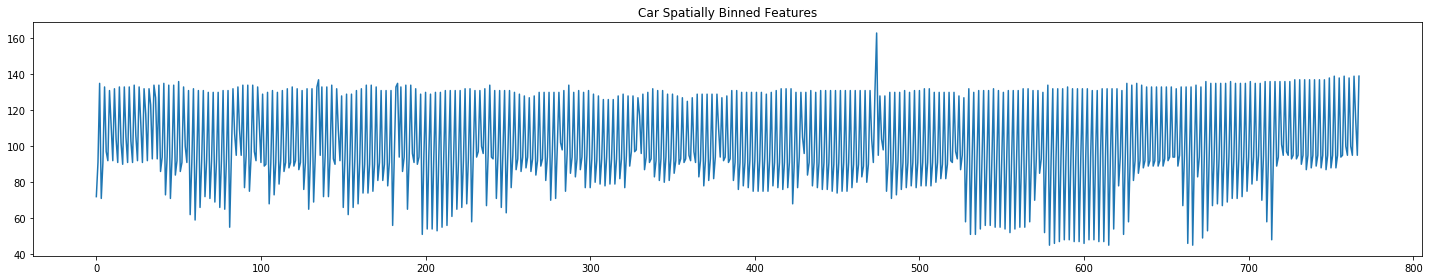

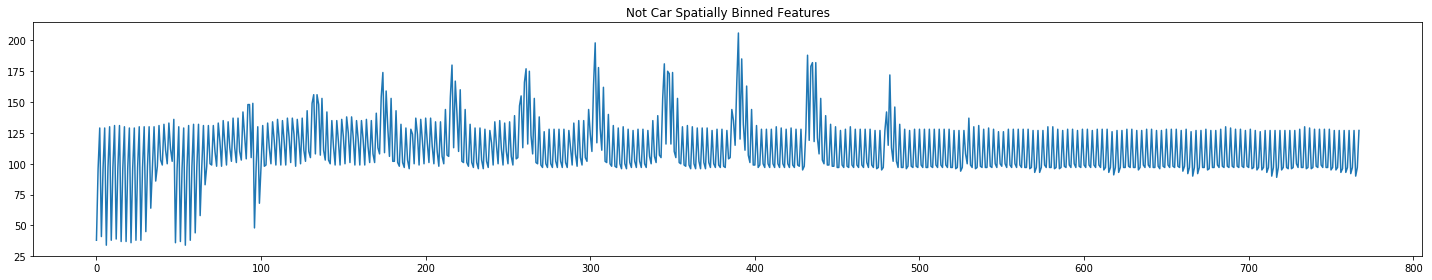

In [9]:
# Read in the image
ind = np.random.randint(0, len(car_images))
ind=10
# Read in the image
car = cv2.imread(cars[ind])
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)

# Read in the image
notcar = cv2.imread(notcars[ind])
notcar = cv2.cvtColor(notcar, cv2.COLOR_BGR2RGB)

cvtd_c = cv2.cvtColor(car, cv2.COLOR_RGB2LUV)
cvtd_nc = cv2.cvtColor(notcar, cv2.COLOR_RGB2LUV)

feature_vec = bin_spatial(cvtd_c, size=(16, 16))
feature_vec2 = bin_spatial(cvtd_nc, size=(16, 16))

print('Shape of color feature vector: ',feature_vec.shape)
    
# Plot features

fig = plt.figure(figsize=(20,4))

plt.plot(feature_vec)
plt.title('Car Spatially Binned Features')
fig.tight_layout()

fig2 = plt.figure(figsize=(20,4))
plt.plot(feature_vec2)
plt.title('Not Car Spatially Binned Features')
fig2.tight_layout()

# Defining function for features extraction

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=3, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Visualizing features 

In [11]:
# Reduce the sample size because HOG features are slow to compute
sample_size = 500
cars_sampled = cars[0:sample_size]
notcars_sampled = notcars[0:sample_size]

#using cars & notcars values from above code blocks
spatial = 16
histbin = 32
#cars_sampled.append(cars[10])
car_features_sampled = extract_features(cars_sampled, color_space='LUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin)
notcar_features_sampled = extract_features(notcars_sampled, color_space='LUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin)

if len(car_features_sampled) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features_sampled, notcar_features_sampled)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars_sampled))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars_sampled[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

# Preparing data for classifier

Extract features from dataset, define labels, shuffle, split data and normalise features

In [12]:
### Tweak these parameters and see how the results change.
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat =True# Histogram features on or off
hog_feat = True # HOG features on or off

# Reduce the sample size because HOG features are slow to compute
#sample_size = 1000
#cars_sampled = cars[0:sample_size]
#notcars_sampled = notcars[0:sample_size]

car_features = extract_features(cars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler -Only required if combining features
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Shape of feature vector:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Shape of feature vector: 2052


# Train a classifier using GridSearchCV

In [13]:
#parameters = {'kernel':('linear', 'rbf'),'C':[0.01, 1], 'gamma':[0.005]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
## Check the training time for the SVC
#t=time.time()
#clf.fit(X_train, y_train)
#t2 = time.time()
#print(round(t2-t, 2), 'Seconds to train classifier...')
## Check the score of the SVC
#print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
## Check the prediction time for a single sample
#t=time.time()

#n_predict = 10
#print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
#print(X_test[0:n_predict].shape)
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])
#t2 = time.time()
#print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with classifier')

#print("Creating pickle file..")
#model = { "clf": clf, "orient": orient, "pix_per_cell": pix_per_cell, "cell_per_block":cell_per_block, 
#        "spatial_size":spatial_size, "hist_bins": hist_bins }
#with open("classifier.pickle", "wb") as f:
#    pickle.dump((model), f)
#print("Done")

# Train a classifier using Linear SVM

In [14]:
from sklearn.svm import LinearSVC
# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Length of Training data:', len(X_train))
print('Length of Test data:', len(X_test))
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.78 Seconds to train SVC...
Length of Training data: 14208
Length of Test data: 3552
Test Accuracy: 98.7613%
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
0.00799 Seconds to predict 10 labels with SVC


# Sliding window approach to find cars in an image

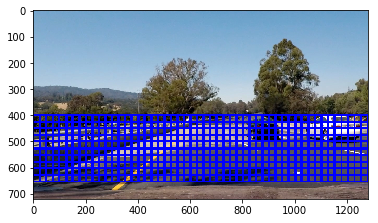

In [15]:
# function to draw rectangles
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched   
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('dataset/test4.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 656], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Apply trained classifier to search for cars in sliding-window image

In [16]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print(test_features.shape)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Extracting HOG features from each individual window 

In [17]:
img = mpimg.imread('dataset/test6.jpg')
draw_img = np.copy(img)
y_start_stop =[400,656]

# Training Data extracted from .png images (scaled 0 to 1 by mpimg)
# Search image is a .jpg (scaled 0 to 255)
img = img.astype(np.float32)/255

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_img, hot_windows)                    

f = plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(window_img)
plt.title('Bounding Boxes')

# Hog Sub-sampling Window Search

Extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) and subsample that array for each sliding window

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins):
    draw_img = np.copy(image)
    image = image.astype(np.float32)/255
    
    img_tosearch = image[ystart:ystop,:,:]  # sub-sampling
    bbxes=[]
  
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
       #select colorspace channel 
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]    
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
   
   # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == "ALL":
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == "ALL":
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
           # test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #save coordinates of bounding boxes
                bbxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                 
    return bbxes, draw_img

## Visualizing find_cars on test images

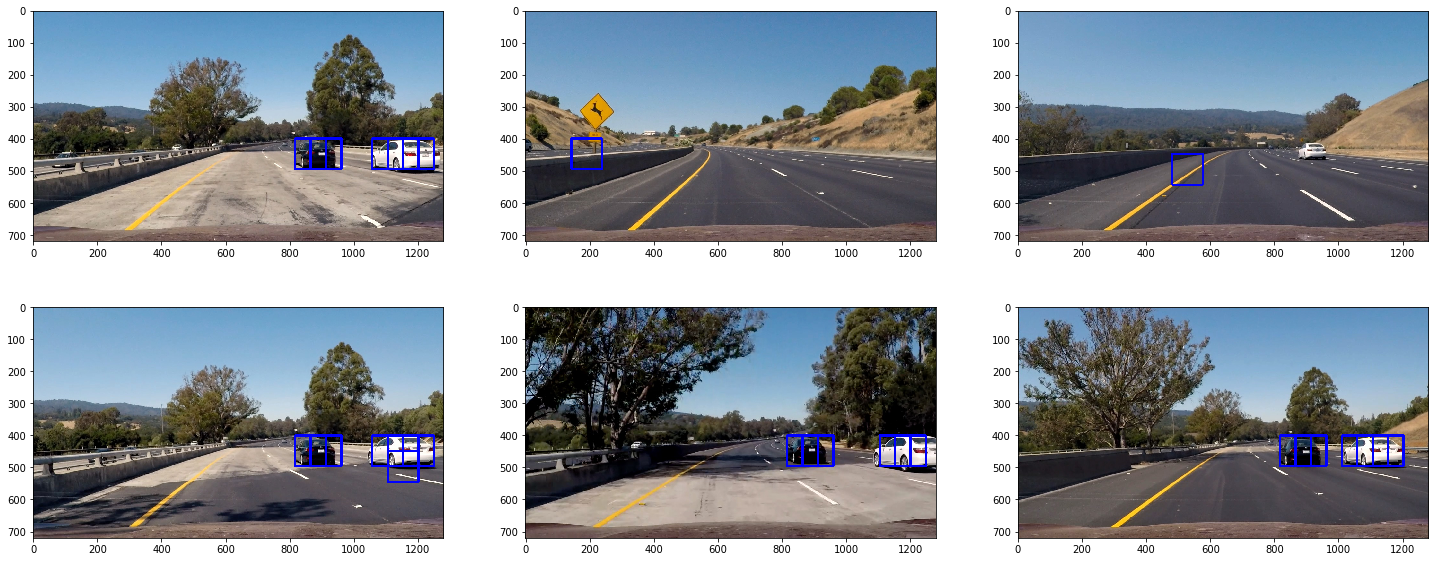

In [19]:
test_images = glob.glob('dataset/test*.jpg')
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
ystart = 400
ystop = 656
scale = 1.5

fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    img = mpimg.imread(im)
    _,out_img = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    axs[i].imshow(out_img)


# Sliding window with multi scale search

find_cars need to be called a few times with different ystart, ystop, and scale values, as the size and position of cars in the image are different depending on their distance from the camera. 

Number of boxes:  13


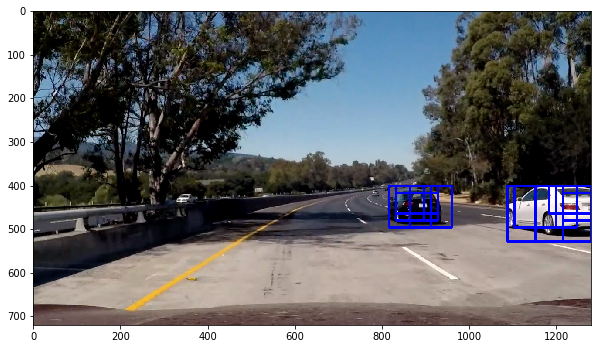

In [20]:
test_image = mpimg.imread('dataset/TEST5.jpg')
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bboxes = []

ystart = 400
ystop = 464
scale = 1.0
bbxes1,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes1)

ystart = 416
ystop = 480
scale = 1.0
bbxes2,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes2)

ystart = 400
ystop = 496
scale = 1.5
bbxes3,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes3)

ystart = 432
ystop = 528
scale = 2.0
bbxes4,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes4)

ystart = 400
ystop = 528
scale = 2.0
bbxes5,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes5)

ystart = 432
ystop = 560
scale = 2.0
bbxes6,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes6)

ystart = 400
ystop = 596
scale = 3.0
bbxes7,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes7)

ystart = 464
ystop = 660
scale = 3.0
bbxes8,out_img = find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
bboxes.extend(bbxes8)

test_img_rects = draw_boxes(test_image, bboxes, color=(0, 0, 255), thick=4)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(bboxes))


In [21]:
def apply_sliding_window(image):
    color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    bboxes = []

    ystart = 400
    ystop = 464
    scale = 1.0
    bbxes1,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes1)

    ystart = 416
    ystop = 480
    scale = 1.0
    bbxes2,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes2)

    ystart = 400
    ystop = 496
    scale = 1.5
    bbxes3,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes3)

    ystart = 432
    ystop = 528
    scale = 2.0
    bbxes4,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes4)

    ystart = 400
    ystop = 528
    scale = 2.0
    bbxes5,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes5)

    ystart = 432
    ystop = 560
    scale = 2.0
    bbxes6,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes6)

    ystart = 400
    ystop = 596
    scale = 3.0
    bbxes7,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes7)

    ystart = 464
    ystop = 660
    scale = 3.0
    bbxes8,out_img = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    bboxes.extend(bbxes8)
    
    return bboxes,out_img

## Visualizing bounding boxes drawn onto test images

In [22]:
test_images = glob.glob('dataset/test*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    test_img2 = mpimg.imread(im)
    boxes, _ = apply_sliding_window(test_img2)
    img_bbxes = draw_boxes(test_img2, boxes, color=(0, 0, 255), thick=4)
    axs[i].imshow(img_bbxes)

# Heatmap

In [23]:
def add_heat(heatmap, bbox_list):
    heatmap = np.zeros((720, 1280)).astype(np.uint8)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

Visualizing heat map on test images

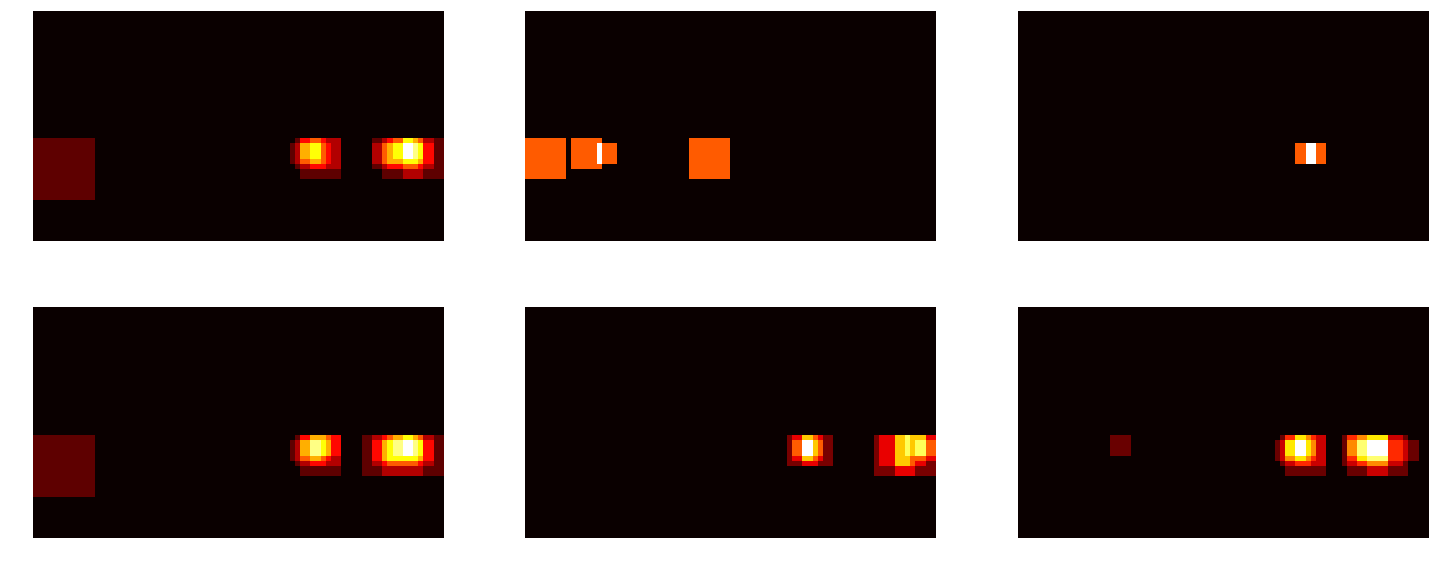

In [24]:
test_images = glob.glob('dataset/test*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)
    bbxes,out_img = apply_sliding_window(image)
    # Test out the heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list

    heat = add_heat(heat, bbxes)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    axs[i].imshow(heatmap, cmap='hot')
    axs[i].axis('off')

# Apply Threshold to the Heatmap - removing false positives

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## Visualizing heatmap after applying threshold on test images

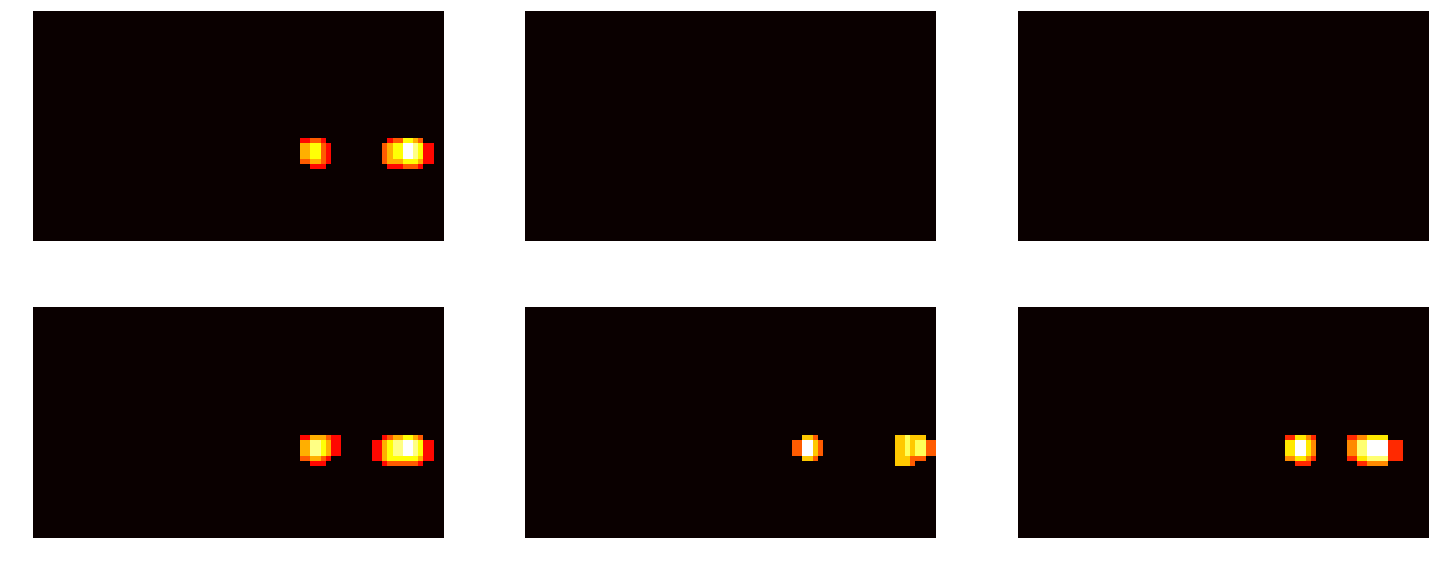

In [26]:
test_images = glob.glob('dataset/test*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)
    bbxes,out_img = apply_sliding_window(image)
    # Test out the heatmap
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list

    heat = add_heat(heat, bbxes)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Apply threshold to help remove false positives
    threshold = 2
    heat = apply_threshold(heat, threshold)
    axs[i].imshow(heat, cmap='hot')
    axs[i].axis('off')

# Apply Labels to Heatmap

In [27]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Visualizing labels on test images

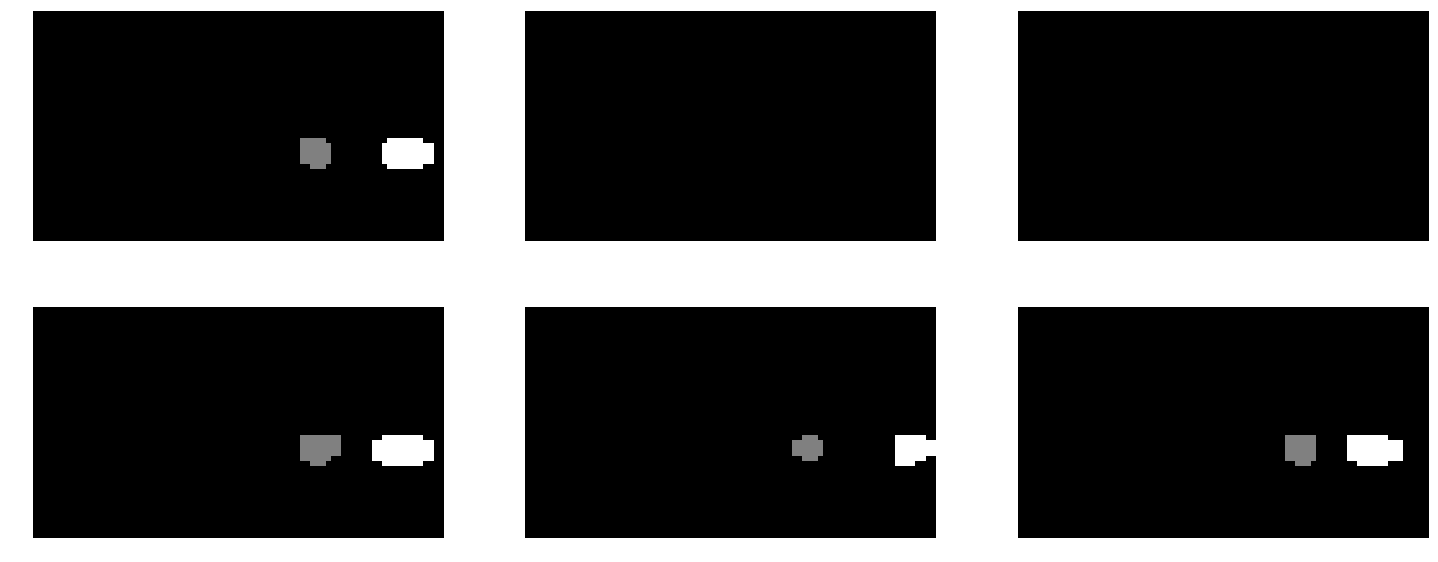

In [28]:
test_images = glob.glob('dataset/test*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)
    bbxes,out_img = apply_sliding_window(image)
    # Test out the heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bbxes)
    
    # Apply threshold to help remove false positives
    threshold =2
    heat = apply_threshold(heat, threshold)
    
    # Find final boxes from heatmap using label function
    labels = label(heat)
    axs[i].imshow(labels[0], cmap='gray')
    axs[i].axis('off')

# Draw Bounding Boxes for Labels found

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        #font = cv2.FONT_HERSHEY_SIMPLEX
        #text = 'car'
        #cv2.putText(img,text, (np.min(nonzerox),np.min(nonzeroy)-12), font, 1, (0,0,255),2)
    # Return the image
    return img

## Visualizing boxes drawn for labels

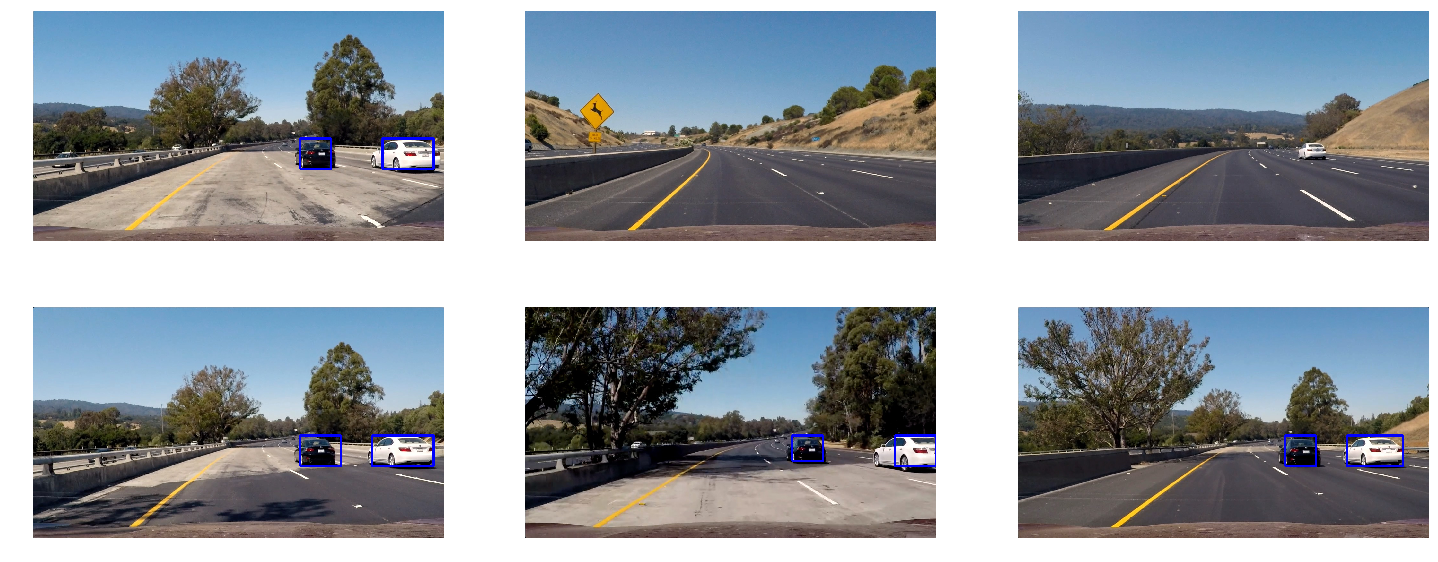

In [30]:
test_images = glob.glob('dataset/test*.jpg')

fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = mpimg.imread(im)
    bbxes,out_img = apply_sliding_window(image)
    # Test out the heatmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bbxes)
    
    # Apply threshold to help remove false positives
    threshold = 2
    heat = apply_threshold(heat, threshold)
    
    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axs[i].imshow(draw_img)
    axs[i].axis('off')

# Pipeline to detect cars in an image

In [31]:
#Create class to hold previously found bounding boxes
class Detector:
    def __init__(self):
        self.prev_bboxes = []
        #self.heatmap = np.array([[],[]])        
    
    def add_bboxes(self, bboxes):
        #append new bounding boxes
        self.prev_bboxes.append(bboxes)
         # delete old bounding boxes
        if len(self.prev_bboxes) > 10:
            self.prev_bboxes = self.prev_bboxes[len(self.prev_bboxes)-10:]


In [32]:
def process_image(image):
    bbxes = []
    bbxes,out_img = apply_sliding_window(image)
    # add detections to the history
    if len(bbxes) > 0:
        det.add_bboxes(bbxes)    
        
    heat_img = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    for boxes in det.prev_bboxes:
        heat_img = add_heat(heat_img, boxes)
    
    # Apply threshold to help remove false positives
    threshold = 2
    heat_img = apply_threshold(heat_img, threshold)
    
    # Find final boxes from heatmap using label function
    labels = label(heat_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)  

    return draw_img

Running the pipeline on an image

In [51]:
det = Detector()
img = mpimg.imread('dataset/test6.jpg')
out = process_image(img)

f = plt.figure(figsize=(12, 12))
plt.imshow(out)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

# Run the Pipeline on a video file

In [34]:
det = Detector()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:18<00:00,  2.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 19.2 s


In [35]:
det = Detector()

test_out_file = 'project_video_out.mp4'
clip_test2 = VideoFileClip('project_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_image)
%time clip_test_out2.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:01<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 10min 1s


# Combining Advanced Lane Finding and Vehicle detection pipelines

## Compute the camera calibration using chessboard images

In [36]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

print('...')

...


In [37]:
import os
%matplotlib inline
    
def corners_unwarp(img, nx, ny, mtx, dist):
    # Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx,dist,None,mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    warped = np.zeros_like(undistorted)
    M = np.zeros_like(undistorted)
    if ret == True:
        #draw corners
       # image = cv2.drawChessboardCorners(undistorted,(nx,ny),corners,ret)
        img_size = (gray.shape[1], gray.shape[0])
        # offset for dst points
        offset = 100 
        #define 4 source points src = np.float32([[,],[,],[,],[,]]) that define a rectangle

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        #define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        #get the transform matrix
        M = cv2.getPerspectiveTransform(src,dst)
        #warp image to a top-down view
        warped = cv2.warpPerspective(undistorted, M,img_size,flags=cv2.INTER_LINEAR)
    return warped, M

# unwarp all images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the images directory and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

## Undistorting road images

In [38]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

## Defining Thresholds

In [39]:
def combined_threshold(img):
    # HLS L channel Threshold - To detect white lines
    l_binary_hls = hls_l_threshold(img)
    
    # LAB L channel to detect shadows in an image
    l_binary = lab_l_threshold(img)
    
    # HLS L channel Threshold - To detect yellow lines
    s_binary = hls_s_threshold(img)  
    
    #LAB B channel to detect yellow lines
    b_binary = lab_b_threshold(img)
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[((l_binary_hls ==1) | (b_binary ==1))] = 1
    
    return combined_binary, l_binary_hls, b_binary

def hls_l_threshold(image, thresh=(200, 255)):
    # Convert to HLS 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    # Apply normalization 
    l_channel = l_channel*(255/np.max(l_channel))  
    # Threshold color channel - To detect white lines
    l_binary = np.zeros_like(l_channel)    
    l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1  
    return l_binary

def hls_s_threshold(image, thresh=(125, 255)):
    # Convert to HLS 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 125
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel > s_thresh_min))] = 1
    return s_binary

def lab_l_threshold(image, thresh=(100, 255)):
     #convert RGB image to LAB image
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #values range from 0-100 (black to white)
    l_channel = lab[:,:,0]
    #values range from -128 to +127 (gives red to green ratio)
    a_channel = lab[:,:,1]
    #values range from -128 to +127 (gives yellow to blue ratio)
    b_channel = lab[:,:,2]  
    
    l_thresh = thresh[0]
    #compute threshold for shadow pixels   
    if int(np.mean(a_channel) + np.mean(b_channel))<= 256:
        l_thresh = np.mean(l_channel) - np.std(l_channel)/3
            
    #pixels with lower values in both L and B planes can be classified as shadow pixels and others
    #as non-shadow pixels
    l_binary = np.zeros_like(l_channel)
    l_binary[((l_channel > l_thresh))] = 1  
        
    return l_binary

def lab_b_threshold(image, thresh=(190, 255)):
     #convert RGB image to LAB image
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #values range from -128 to +127 (gives yellow to blue ratio)
    b_channel = lab[:,:,2]    
    # normalize image if yellow found in the image
    if np.max(b_channel) > 175:
        b_channel = b_channel*(255/np.max(b_channel)) 
    b_binary = np.zeros_like(b_channel)    
    b_binary[((b_channel > thresh[0]) & (b_channel <= thresh[1]))] = 1
    return b_binary

## Finding Region of Interest 

In [40]:
#select region of interest in the image
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #define a 4 sided polygon to mask
    imshape = img.shape     
    #vertices = np.array([[(135,imshape[0]),(580, 460), (730, 460), (1200,imshape[0])]], dtype=np.int32)
    vertices = np.array([[(135,imshape[0]),(580, 460), (730, 460), (1200,imshape[0])]], dtype=np.int32)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Helper functions to warp, search for lanes and draw lines

In [41]:
#Apply Warp Perspective
def perspective_transform(image):
    #undistort an image
    #undist = cv2.undistort(image, mtx, dist, None, mtx)
    #define source points src = np.float32([[,],[,],[,],[,]]), using masked vertices
    imgsize = (image.shape[1], image.shape[0])
    vertices = np.array([[(135,imgsize[1]),(580, 460), (730, 460), (1200,imgsize[1])]], dtype=np.int32)
    #draw polygon on original image
    vertices = vertices.reshape((-1,1,2))
    pts = vertices.reshape(4, 2)
    src = np.float32([pts[0],pts[3], pts[2], pts[1] ])

    #chose destination points 
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 0]
    top_right = [920, 0]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])

    #get the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    #warp image to a top-down view
    binary_warped = cv2.warpPerspective(image, M,imgsize,flags=cv2.INTER_LINEAR)
    
    return binary_warped,M, Minv

def blind_search(binary_warped):
    # Take a histogram of the bottom half of the image
    # adding up the pixel values along each column in the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    # Break image into 9 vertical layers since image height is 720
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
   
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # append windows to rectangles
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit, right_fit = None, None 
    if len(leftx) == 0:
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) == 0:
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2) 
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,rectangles

#Once we know where the left and right line are using left_fit and right_fit, we 
#can just use the previous line positions without doing a blind search again
def quick_lane_finder(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
     # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) == 0:
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2) 
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds

#Radius of curvature in world space, in meters
def radius_of_curvature(binary_warped,left_fitx, right_fitx):
    img_size = binary_warped.shape
    ploty = np.linspace(0, img_size[0]-1, img_size[0] )
    left_curverad, right_curverad = 0,0 
    #y vlues of image increases from top to bottom;
    #to measure radius of curvature closest to the vehicle, I'll choose the maximum y-value, 
    #corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    #U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, 
    #and the dashed lane lines are 10 ft = 3.048 meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/510 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    return left_curverad, right_curverad

# Create an image to draw the lines on
def drawLine(binary_warped,left_fit, right_fit, Minv, image):
    if left_fit is None or right_fit is None or len(left_fit) ==0 or len(right_fit) ==0:
        return image,color_warp
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result, color_warp

In [42]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def save_fit(self, fit):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # bad fit
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # delete old fits, keep new n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [43]:
#Function to process the image
def Lane_detection(image):
    prcsd_img = process_image(image)
    average_curverad, center_offset_mtrs = 0,0
    left_fitx, right_fitx = None, None

    #Apply distortion correction to raw images.
    undistorted = undistort(prcsd_img)

    #get combined binary image
    combined_binary,_,_,=  combined_threshold(undistorted) 

    #mask image
    masked_img = region_of_interest(combined_binary)

    #perspective transform
    binary_warped,M,Minv = perspective_transform(masked_img)
  
    #if left and right lines were detected in previous frame, 
    #use quick_lane_finder, otherwise perform a blind_search     
    if not left.detected or not right.detected:       
        left_fit,right_fit,left_lane_inds,right_lane_inds,_ = blind_search(binary_warped)
    else:
        left_fit,right_fit,left_lane_inds,right_lane_inds = quick_lane_finder(binary_warped,left.best_fit,right.best_fit)   
   
    # Calculate x-intercept
    if left_fit is not None and right_fit is not None:
        # left_fit_x and right_fit_x are the x-intercepts of the left and right fits
        # respectively. Maximum y value is 719, in this case - the bottom of the image)
        h = binary_warped.shape[0]
        left_fit_x = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_diff = abs(right_fit_x - left_fit_x)
        # invalidate fits if x-intercepts isn't around 460 px (with some offset i.e., 100px)
        if abs(460-x_diff) > 100:
            left_fit = None
            right_fit = None   

    left.save_fit(left_fit)
    right.save_fit(right_fit)
    
     # draw the current best fit if it exists
    if left.best_fit is not None and right.best_fit is not None:
        #Warp back to original and merge with image
        img_out, warp_img = drawLine(binary_warped, left.best_fit, right.best_fit, Minv, undistorted)
        
        #calculate left and right polynomial fits
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left.best_fit[0]*ploty**2 + left.best_fit[1]*ploty + left.best_fit[2]
        right_fitx = right.best_fit[0]*ploty**2 + right.best_fit[1]*ploty + right.best_fit[2]
        
        #once we have polynomial fits, we can calculate the radius of curvature
        if left_fitx is not None and right_fitx is not None:
            #Determine the curvature of the lane and vehicle position with respect to center.  
            left_curverad, right_curverad = radius_of_curvature(binary_warped,left_fitx,right_fitx)  
            average_curverad = (left_curverad + right_curverad)/2
    
           # compute the offset from the center
          # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
            lane_center = (left_fitx[719] + right_fitx[719])/2
            xm_per_pix = 3.7/510 # meters per pixel in x dimension
            center_offset_pixels = abs(binary_warped.shape[1]/2 - lane_center)
            center_offset_mtrs = xm_per_pix*center_offset_pixels
    else:
        img_out,warp_img = np.copy(image),np.copy(image)

   
    #Write curvature and center on the image
    Average = "Radius of curvature: " + str(round(int(average_curverad),4)) + " m"
    TextC = "Center offset: " + str(round( center_offset_mtrs,2)) + " m"
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX    
    
    cv2.putText(img_out, Average, (50,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (50,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)    
    #cv2.putText(prcsd_img, "Threshold view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(prcsd_img, "Top down view", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    return img_out

## Complete pipeline for advanced lane finding and vehicle detection

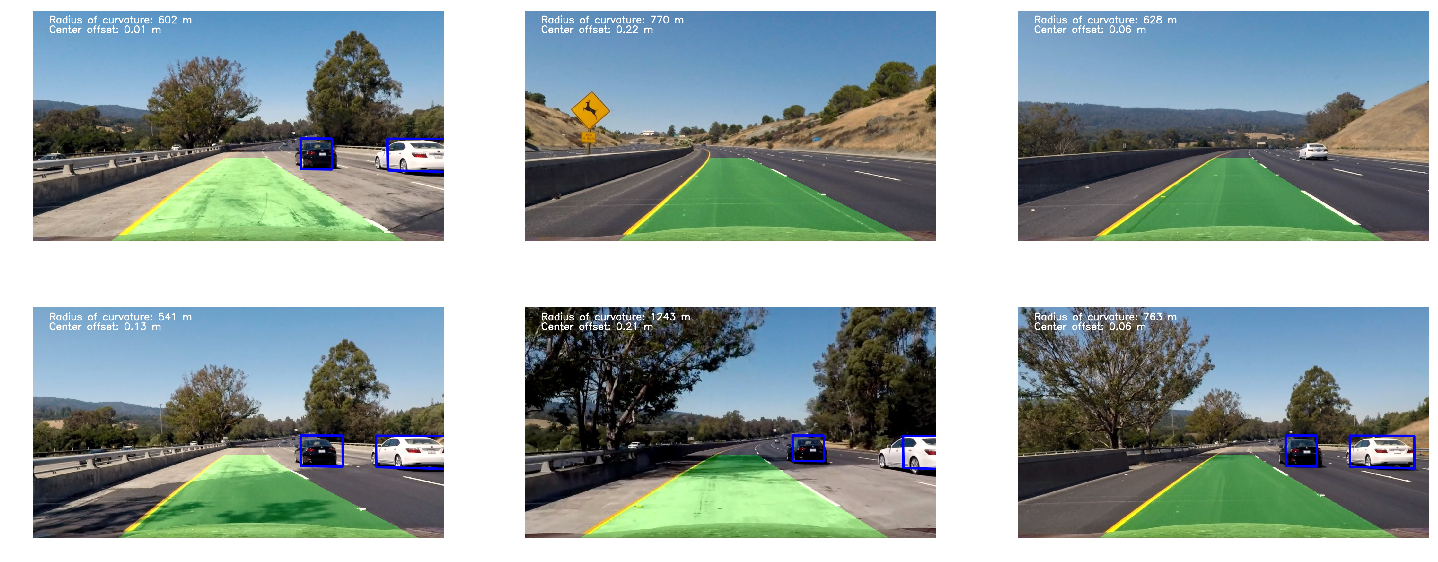

In [50]:
test_images = glob.glob('dataset/test*.jpg')
fig, axs = plt.subplots(2, 3, figsize=(25,10))
axs = axs.ravel()

for i, im in enumerate(test_images):
    left = Line()
    right = Line()
    det = Detector()
    img_in = mpimg.imread(im)
    img_out = Lane_detection(img_in)
    axs[i].imshow(img_out)
    axs[i].axis('off')


In [45]:
left = Line()
right = Line()
det = Detector()
output = 'project_video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(Lane_detection)#.subclip(1,10) #NOTE: this function expects color images!!
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:38<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

Wall time: 12min 39s
